<a href="https://colab.research.google.com/github/ArshiAbolghasemi/AI-UT/blob/main/clustering/image_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project we want using clustering algorithms, analysing flowers pictures an d then based on our data put them into different clusters

# Imports And Settings

## Imports

In [118]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from dataclasses import dataclass
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, homogeneity_score

## Settings

In [4]:
# DataSet
DATASET_PATH=os.path.join(os.getcwd(), 'drive/MyDrive/AI-UT/clustering/data')
FLOWER_IMAGES_PATH=os.path.join(DATASET_PATH, 'flower_images/')

# Feature Extraction
IMG_HEIGHT=224
IMG_WIDTH=224

# K-Means
NUM_ITER_K_MEANS=300

## Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing and Feature Extraction
In this section, we are going to extract information from images using VGG16.

1. Why do we need feature extraction? why dont we only read raw pixel? explain it.
> Instead of using the raw pixels directly, features represent more abstract and meaningful characteristics, such as edges, textures, or shapes.<br>
> Advantages of feature extraction include:<br>
> - **Dimensionality Reduction:** Extracted features often have lower dimensionality than raw pixel data, reducing the complexity of the data and computation.
> -**Increased Robustness:** Features focus on important aspects, making models more robust to variations like changes in lighting, rotation, or scale.
> - **Improved Generalization:** Features highlight relevant information, helping models generalize better to new, unseen data by emphasizing key patterns.
> - **Enhanced Interpretability:** Features can provide insights into the image content, aiding in the interpretability of the model's decisions.
> - **Computational Efficiency:** Working with extracted features is computationally more efficient than processing raw pixel values, enabling faster training and inference. <br>
> - Overall, feature extraction enhances the performance and interpretability of image processing models by transforming raw pixel data into a more meaningful and manageable representation.

2. Explain three ways of feature extraction Theqniques from images.
>- **Convolutional Neural Networks(CNN)**: CNNs are generally the preferred choice for feature extraction from images because CNNs are specifically designed for processing color images and perform more complex tasks such as image classification, object detection, or segmentation where it can extract complex and descriptive features with any variations such as lighting conditions, scale, and other factors in the image. It is useful in situations where you want to have high accuracy after processing your images, thus making it the most efficient way.<br>
>- **Mean pixel values of channels**: It is a very basic image feature extraction technique where we calculate the mean intensity of each color channel (red, green, and blue) in an image. This approach can be useful in situations where the goal is to perform a simple image processing operation or to obtain a basic representation of the image such as thumbnail creation, image compression and resizing. However, mean pixel value of channels is generally not a suitable technique for more complex tasks such as image classification, object detection, or segmentation. This is because mean pixel value of channels does not take into account the spatial relationship between the pixels in the image, and it does not consider the relationship between different channels.<br>
>- **Local Binary Patterns (LBP)**: Local Binary Patterns (LBP) is a widely used feature extraction method for analyzing texture information in images. LBP captures the local structure of an image by comparing the gray values of a pixel to its surrounding neighbors and encoding the result into a binary pattern. LBP features are often used where there is limited data and in machine learning algorithms for various computer vision tasks such as face recognition, texture analysis, and object recognition. LBP is computationally efficient and can operate in real-time applications, such as surveillance and tracking systems, where the processing speed is crucial.

3. Which preprocessing should be applied to image data to prepare it for input into a model?
> There are several techniques used in image preprocessing:
> - Resizing: Resizing images to a uniform size is important for machine learning algorithms to function properly.
> - Grayscaling: Converting color images to grayscale can simplify your image data and reduce computational needs for some algorithms.
> - Noise reduction: Smoothing, blurring, and filtering techniques can be applied to remove unwanted noise from images.
> - Normalization: Normalization adjusts the intensity values of pixels to a desired range, often between 0 to 1. This can improve the performance of machine learning models.
> - Binarization: Binarization converts grayscale images to black and white by thresholding.
> - Contrast enhancement: The contrast of images can be adjusted using histogram equalization.

## Load Dataset
First Let's read our image dataset

In [7]:
@dataclass
class Flower:
  file_path: str
  image: np.ndarray
  label: str
  features: np.ndarray

In [8]:
labels = pd.read_csv(os.path.join(DATASET_PATH, 'flower_labels.csv'))

In [9]:
def load_images(labels: pd.DataFrame) -> List[Flower]:
  flowers = []
  for flower_image in os.listdir(FLOWER_IMAGES_PATH):
    try:
      image = cv2.imread(os.path.join(FLOWER_IMAGES_PATH, flower_image))
      if image is None:
        print(f"failed to read {flower_image}.")
        continue
      label = labels.loc[labels.file == flower_image, 'label'].iloc[0]
      flowers.append(Flower(image=cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)),
                            file_path=os.path.join(FLOWER_IMAGES_PATH, flower_image),
                            label=label,
                            features=None))
    except Exception as e:
      print(f"{str(e)}")

  return sorted(flowers, key=lambda flower: flower.file_path)

In [10]:
flowers = load_images(labels)

## Feature Extraction


First, let's create our VGG16 model

In [11]:
vgg16 = VGG16(weights='imagenet', include_top=True)
vgg16.summary()

553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Next, using VGG16, we are going to extract features from our images.

In [12]:
def extract_features(flowers: List[Flower], model: VGG16=vgg16) -> None:
  feat_extractor = Model(inputs=model.input, outputs=model.get_layer('fc2').output)
  for flower in flowers:
    img = flower.image
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    flower.features = feat_extractor.predict(img)

In [13]:
extract_features(flowers)

1/1 [==============================] - 1s 801ms/step


## Data Preprocessing

Before we start, let's normalize our features

In [14]:
features = np.array([flower.features.flatten() for flower in flowers])
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Clustering
Here, using two clustering algorithms, **K-Means** and **DBSCAN**, and the feature vectors from the previous section, we are going to cluster our images.


4. Compare K-Means and DBSCAN pros and cons.
> **KMean** <br>
> pros:<br>
> Simple and easy to implement.
> Computationally efficient, especially for large datasets and low-dimensional data.<br>
>  Scales well to a large number of samples.
>  Produces tight, well-separated clusters when the data is well-separated and spherical.<br>
> Generally performs well when the clusters are evenly sized and have similar density.<br>
> cons:<br>
>Requires the number of clusters (k) to be specified in advance, which may not always be known.<br>
> Sensitive to the initial selection of cluster centroids, which can lead to suboptimal solutions.<br>
> Prone to convergence to local minima, especially when clusters have different sizes, densities, or non-spherical shapes.<br>
> Assumes clusters are spherical and have similar density, which may not be true for all datasets<br>
>Does not work well with clusters of different sizes or densities, or when clusters have irregular shapes or non-linear boundaries.<br>
> **DBSCAN**<br>
> pros:
> Does not require specifying the number of clusters in advance.<br>
> Can discover clusters of arbitrary shapes and sizes.<br>
> Robust to outliers and noise in the data.<br>
> Does not assume clusters have a spherical shape or similar density.
Can handle clusters with varying densities and non-linear boundaries effectively.<br>
> cons:
> Computationally more expensive than K-means, especially for large datasets.<br>
> Requires tuning of two parameters: epsilon (ε) and min_samples, which may not always be straightforward.<br>
Performance may degrade in high-dimensional spaces due to the curse of dimensionality.<br>
> Not suitable for clusters with varying densities if a single epsilon value is used.<br>
> May produce overlapping clusters if epsilon is set too low or too high, or if min_samples is set too low.<br>




## K-Means

### Identify Optimum Number of clusters
First, let's select the appropriate k using an elbow plot.

5. Describe the method used to find the appropriate K in K-Means.
Plot the inertia (sum of squared distances of samples to their closest cluster center) as a function of the number of clusters and look for the "elbow" point, where the rate of decrease in inertia slows down. The point at which adding more clusters does not significantly decrease inertia is often chosen as the optimal number of clusters.

In [15]:
def optimize_number_of_clusters(features: np.ndarray, max_k: int) -> None:
  cluster_counts = []
  inertias = []

  for k in range(1, max_k):
    model = KMeans(n_clusters=k, init='k-means++',
                   max_iter=NUM_ITER_K_MEANS,
                   n_init=10)
    model.fit(features)
    inertias.append(model.inertia_)
    cluster_counts.append(k)

  plt.subplots(figsize=(10,5))
  plt.plot(range(1, max_k), inertias, 'o-')
  plt.xlabel('Number of clusters (K)')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

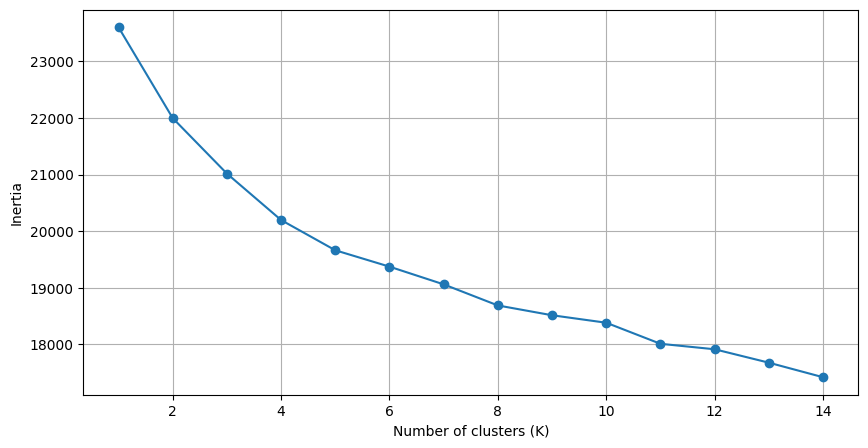

In [16]:
optimize_number_of_clusters(normalized_features, 15)

So, we choose 10 as number of clusters.

### Applying K-Means Clustering

In [17]:
kmeans = KMeans(n_clusters=10, max_iter=NUM_ITER_K_MEANS, n_init=10)

In [18]:
kmenas_clusters = kmeans.fit_predict(normalized_features)

In [19]:
labels['K_Means_label'] = kmenas_clusters

In [20]:
labels

,file,label,K_Means_label
0,0001.png,0,7
1,0002.png,0,7
2,0003.png,2,2
3,0004.png,0,7
4,0005.png,0,7
...,...,...,...
205,0206.png,6,2
206,0207.png,0,7
207,0208.png,4,1
208,0209.png,6,7


## DBSCAN

### HyperParameters
First, we should choose our hyper parameters, **MinPoints** and **Epsilon**

In [111]:
eps=6
min_samples=3

### Applying DBSCAN


In [112]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

In [113]:
dbscan_clusters = dbscan.fit_predict(normalized_features)

In [114]:
labels['DBSCAN_label'] = dbscan_clusters

In [115]:
labels

,file,label,K_Means_label,DBSCAN_label,PCA_K_Means_label,PCA_DBSCAN_label
0,0001.png,0,7,-1,7,-1
1,0002.png,0,7,-1,7,-1
2,0003.png,2,2,-1,1,0
3,0004.png,0,7,-1,1,-1
4,0005.png,0,7,-1,5,-1
...,...,...,...,...,...,...
205,0206.png,6,2,-1,5,-1
206,0207.png,0,7,-1,7,-1
207,0208.png,4,1,-1,4,-1
208,0209.png,6,7,-1,7,-1


In DBSCAN, minus one indicates noise data

Now compare reuslt of each clustering algorithms

In [109]:
labels['label'].value_counts()

label
8    26
5    25
6    23
3    22
0    21
4    21
1    20
2    19
9    18
7    15
Name: count, dtype: int64

In [27]:
labels['K_Means_label'].value_counts()

K_Means_label
2    39
7    33
3    26
8    25
1    21
5    21
0    20
4    19
9     5
6     1
Name: count, dtype: int64

In [116]:
labels['DBSCAN_label'].value_counts()

DBSCAN_label
-1    207
 0      3
Name: count, dtype: int64

# Dimenssion Reduction

7. Explain PCA.
>PCA is a dimensionality reduction technique used in statistics and machine learning to transform high-dimensional data into a lower-dimensional representation, preserving the most important information.<br>
>Principal components are linear combinations of the original features that PCA finds and uses to capture the most variance in the data. In order of the amount of variance they explain, these orthogonal components are arranged.<br>
>Principal components represent the directions in which the data varies the most. The first few components typically capture the majority of the data’s variance, allowing for a more concise representation.<br>
>PCA is widely used for various purposes, including data visualization, noise reduction, and feature extraction. It helps in identifying underlying patterns in high-dimensional data and simplifying complex datasets for further analysis.<

In [29]:
pca = PCA(0.95)

In [30]:
normalized_features.shape

(210, 4096)

In [31]:
pca_normalized_features = pca.fit_transform(normalized_features)
pca_normalized_features.shape

(210, 145)

In [32]:
pca.explained_variance_ratio_

array([0.09164181, 0.064248  , 0.04520221, 0.03465944, 0.03170927,
       0.02655021, 0.02466763, 0.0232564 , 0.02127952, 0.01983738,
       0.01802753, 0.0166905 , 0.01563057, 0.01488833, 0.0135938 ,
       0.01285281, 0.01227105, 0.01189016, 0.01149432, 0.01143905,
       0.0105417 , 0.01047985, 0.00994658, 0.00942224, 0.00914317,
       0.00854858, 0.00829798, 0.00817369, 0.00778043, 0.00751985,
       0.00734181, 0.00689832, 0.00672026, 0.00663405, 0.00638711,
       0.00627687, 0.00612375, 0.00596528, 0.0057398 , 0.00565625,
       0.00554855, 0.00542881, 0.00525513, 0.0050383 , 0.00497734,
       0.00489308, 0.00486815, 0.00473451, 0.00463778, 0.00453535,
       0.0044896 , 0.0044147 , 0.00434035, 0.00412937, 0.00410053,
       0.00400811, 0.00395601, 0.00383504, 0.0037904 , 0.00374309,
       0.00368323, 0.00364064, 0.00357298, 0.00349218, 0.00341885,
       0.00336414, 0.00333275, 0.00330719, 0.00330063, 0.00315768,
       0.0030927 , 0.00305272, 0.00301179, 0.0029784 , 0.00294

## K-Means

### Identify Optimum Number of clusters

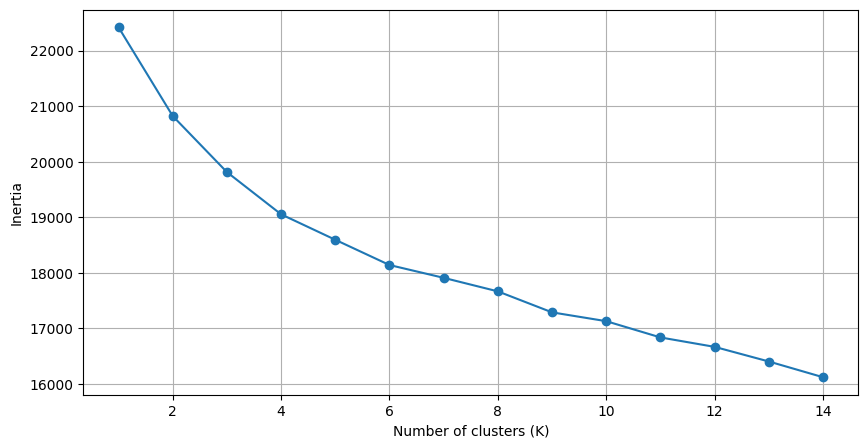

In [34]:
optimize_number_of_clusters(pca_normalized_features, 15)

So, we choose 10 for number of clusters

### Applying K-Means Clustering

In [35]:
kmeans_pca = KMeans(n_clusters=10, max_iter=NUM_ITER_K_MEANS, n_init=10)

In [36]:
pca_kmeans_clusters = kmeans_pca.fit_predict(pca_normalized_features)

In [37]:
labels['PCA_K_Means_label'] = pca_kmeans_clusters

In [38]:
labels

,file,label,K_Means_label,DBSCAN_label,PCA_K_Means_label
0,0001.png,0,7,0,7
1,0002.png,0,7,0,7
2,0003.png,2,2,0,1
3,0004.png,0,7,-1,1
4,0005.png,0,7,0,5
...,...,...,...,...,...
205,0206.png,6,2,-1,5
206,0207.png,0,7,-1,7
207,0208.png,4,1,-1,4
208,0209.png,6,7,0,7


In [39]:
labels['PCA_K_Means_label'].value_counts()

PCA_K_Means_label
7    46
1    46
5    43
4    21
8    18
3    15
6     9
0     6
2     5
9     1
Name: count, dtype: int64

<ipython-input-40-fe0c0905db27>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_normalized_features[pca_kmeans_clusters == cluster_label, 0],


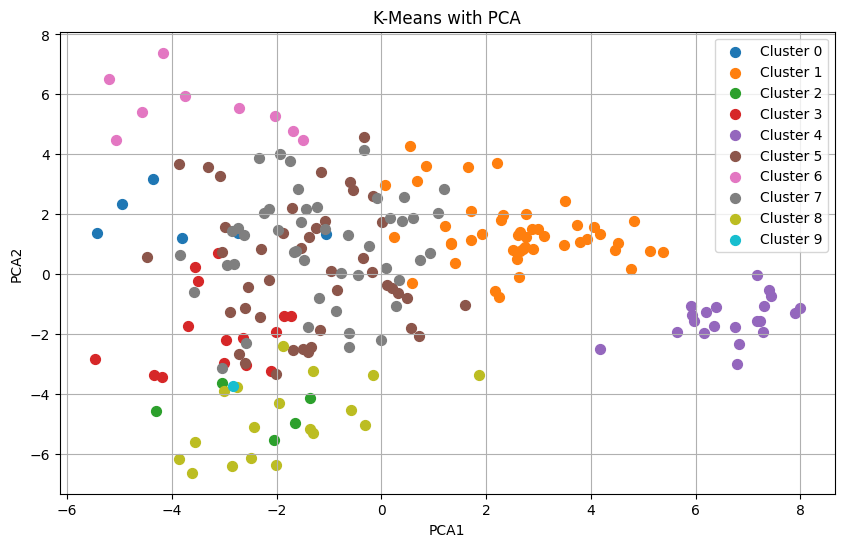

In [40]:
plt.figure(figsize=(10, 6))
for cluster_label in np.unique(pca_kmeans_clusters):
  plt.scatter(pca_normalized_features[pca_kmeans_clusters == cluster_label, 0],
              pca_normalized_features[pca_kmeans_clusters == cluster_label, 1],
              label=f'Cluster {cluster_label}', cmap='viridis', marker='o',
              s=50)
plt.title('K-Means with PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid(True)
plt.show()

## DBSCAN

### HyperParameters

In [97]:
pca_eps=5
pca_min_samples=3

### Applying DBSCAN

In [98]:
pca_dbscan = DBSCAN(eps=pca_eps, min_samples=pca_min_samples)

In [99]:
pca_dbscan_clusters = pca_dbscan.fit_predict(pca_normalized_features)

In [100]:
labels['PCA_DBSCAN_label'] = pca_dbscan_clusters

In [101]:
labels

,file,label,K_Means_label,DBSCAN_label,PCA_K_Means_label,PCA_DBSCAN_label
0,0001.png,0,7,0,7,-1
1,0002.png,0,7,0,7,-1
2,0003.png,2,2,0,1,0
3,0004.png,0,7,-1,1,-1
4,0005.png,0,7,0,5,-1
...,...,...,...,...,...,...
205,0206.png,6,2,-1,5,-1
206,0207.png,0,7,-1,7,-1
207,0208.png,4,1,-1,4,-1
208,0209.png,6,7,0,7,-1


In [102]:
labels['PCA_DBSCAN_label'].value_counts()

PCA_DBSCAN_label
-1    197
 0      5
 2      5
 1      3
Name: count, dtype: int64

<ipython-input-103-c9ee33375b2c>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_normalized_features[pca_dbscan_clusters == cluster_label, 0],


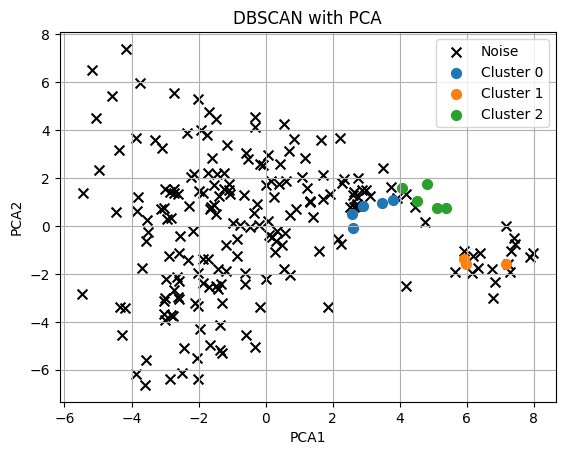

In [103]:
for cluster_label in np.unique(pca_dbscan_clusters):
    if cluster_label == -1:
        plt.scatter(pca_normalized_features[pca_dbscan_clusters == cluster_label, 0],
                    pca_normalized_features[pca_dbscan_clusters == cluster_label, 1],
                    label='Noise', color='black', marker='x', s=50)
    else:
        plt.scatter(pca_normalized_features[pca_dbscan_clusters == cluster_label, 0],
                    pca_normalized_features[pca_dbscan_clusters == cluster_label, 1],
                    label=f'Cluster {cluster_label}', cmap='viridis',
                    marker='o', s=50)
plt.title('DBSCAN with PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation and Analysis

## Silhouette

The silhouette coefficient is a metric that measures how well each data point fits into its assigned cluster. It combines information about both the cohesion (how close a data point is to other points in its own cluster) and the separation (how far a data point is from points in other clusters) of the data point.<br>
The coefficient ranges from -1 to 1, where a value close to 1 indicates a well-clustered data point, a value close to 0 suggests overlapping clusters, and a value close to -1 indicates a misclassified data point.<br>
**Calculating the Silhouette Coefficient: Step-by-Step**


*   For each data point, calculate two values
    - Average distance to all other data points within the same cluster (cohesion).
    - Average distance to all data points in the nearest neighboring cluster (separation).

*   Compute the silhouette coefficient for each data point using the formula<br>
$$
silhouette coefficient = (separation — cohesion) / max(separation, cohesion)
$$

*   Calculate the average silhouette coefficient across all data points to obtain the overall silhouette score for the clustering result.

In summary, a higher silhouette score indicates better-defined clusters with samples well-separated from neighboring clusters. It is a valuable tool for assessing the appropriateness of the number of clusters chosen and for comparing different clustering algorithms or parameter settings.



Now let's evaluate our models usign this tool

In [119]:
ss_kmeans = silhouette_score(normalized_features, kmenas_clusters)
ss_kmeans

0.038480897

In [120]:
ss_dbscan = silhouette_score(normalized_features, dbscan_clusters)
ss_dbscan

-0.10665953

In [122]:
ss_pca_kmeans = silhouette_score(pca_normalized_features, pca_kmeans_clusters)
ss_pca_kmeans

0.051115055

In [123]:
ss_pca_dbscan = silhouette_score(pca_normalized_features, pca_dbscan_clusters)
ss_pca_dbscan

-0.15947625

## Homogeneity

Homogeneity measures how much the sample in a cluster are similar.<br>
Homogeneity is often calculated using external evaluation metrics, such as the Adjusted Mutual Information (AMI) or the V-measure. These metrics compare the clustering results with the true class labels to determine the homogeneity of the clusters.<br>


*   **Adjusted Mutual Information (AMI):** AMI measures the agreement between the clustering result and the true class labels, while adjusting for chance.
*   **V-measure:** V-measure is the harmonic mean of homogeneity and completeness, where homogeneity measures how well each cluster contains only data points from a single class



Now let's evaluate our models usign this tool

In [125]:
hs_kmeans = homogeneity_score(labels['label'], labels['K_Means_label'])
hs_kmeans

0.46613605861665297

In [127]:
hs_dbscan = homogeneity_score(labels['label'], labels['DBSCAN_label'])
hs_dbscan

0.015454376725708555

In [126]:
hs_pca_kmeans = homogeneity_score(labels['label'], labels['PCA_K_Means_label'])
hs_pca_kmeans

0.4457824625543256

In [128]:
hs_pca_dbscan = homogeneity_score(labels['label'], labels['PCA_DBSCAN_label'])
hs_pca_dbscan

0.07070412010673481

10. Suggest ways to improve our model's performance.
>- **Feature Engineering**: Explore different feature extraction techniques or modify existing ones to capture more meaningful information from images. Experiment with various architectures of deep learning models or use pre-trained models to extract features.
>- **Data Augmentation**: Augment the dataset with additional images or apply data augmentation techniques to increase the diversity of the data and improve the generalization ability of the models.
>- **Evaluation Metrics**: Use a variety of evaluation metrics, such as Silhouette score, Davies–Bouldin index, or Adjusted Rand Index, to quantitatively assess the quality of the clustering results and guide the improvement process.
>- **Ensemble Methods**:
Ensemble methods in clustering involve combining multiple base clustering algorithms to improve overall clustering performance. These methods leverage the diversity of individual clustering algorithms and exploit the collective wisdom of multiple models to produce more robust and accurate clustering results.
>- **Post Processing**: Post-processing in clustering refers to the set of techniques applied after the initial clustering step to refine or improve the quality of the clustering results. These techniques aim to address issues such as noise, outliers, and suboptimal cluster assignments that may arise during the clustering process.